“Text Summarization using Graph-Based TextRank Algorithm”

🎯 Project Goal

Develop an algorithm that automatically summarizes long texts by identifying and extracting the most important Articles, using a graph-based ranking approach inspired by Google’s PageRank.

So, so far the algorithms are : 1-graph 2- sorting and ranking

⚙️ Algorithm (Summary)

Input: text string, number of summary Articles 
𝑘
k

Output: top-
𝑘
k ranked Articles (summary)

Pseudocode:

1. Split the input text into Articles S = [s1, s2, ..., sn]
2. Clean and tokenize each Article (remove stopwords, punctuation)
3. For each pair (i, j), compute similarity sim(si, sj)
4. Build weighted graph G with edges (i, j, sim)
5. Initialize ranks Ri = 1/n for all Articles
6. Repeat until convergence:
       Ri_new = (1 - d) + d * sum_j( wji / sum_k(wjk) * Rj )
7. Sort Articles by Ri descending
8. Select top-k and preserve original order
9. Return the selected Articles as summary

| Stage                 | Complexity       | Notes                                    |
| --------------------- | ---------------- | ---------------------------------------- |
| Article tokenization | (O(n))           | n = # of Articles                       |
| Pairwise similarity   | (O(n^2 \cdot L)) | L = avg Article length                  |
| Graph iteration       | (O(n^2 \cdot T)) | T = # of iterations (~20–50)             |
| Total                 | (O(n^2))         | Feasible for up to hundreds of Articles |


Data structure choice:

Articles: list of strings

Tokens: list of words per Article

Graph: adjacency list {i: [(j, weight)]}

Ranks: dict or list [float]

🧪 Implementation Plan
Phase 1 — Core Algorithm (Toy Example)

Hardcode one or two small paragraphs.

Implement tokenization, similarity, and iterative rank update with pure Python only.

Print final Article scores and summary.

Phase 2 — Full Dataset

Load multiple news articles (e.g., BBC dataset on Kaggle
)

Use same algorithm; you may use NumPy for matrix ops only at this stage.

Phase 3 — Evaluation

Qualitative: Does summary capture the main idea?

Quantitative (optional): Compute ROUGE-1 or ROUGE-L if reference summaries available.

Compare variants:

Word overlap vs. cosine TF–IDF similarity

With/without stopwords

Different damping factors (0.85 vs 0.9)

🪄 Possible Extensions (for bonus points / CV polish)

Add redundancy penalty (avoid similar top Articles).

Try phrase-based summarization (extract key noun phrases).

Visualize the Article graph using networkx later (not needed for the toy).

Build a command-line tool:

🧮 Practical Tips

Start small: Pick ~10 articles to debug, because computing pairwise Article similarity for large docs can be heavy in pure Python.

Article length cutoff: Ignore Articles shorter than 5 words or longer than 50 words to clean noise.

Stopwords: Create a small stopword list manually (common English words).

Evaluation: Compare your top-k extracted Articles against highlights. You can check for keyword overlap or compute simple recall of key nouns.

#### **DATA**


In [1]:
import pandas as pd
import numpy as np

In [ ]:
# data = pd.read_csv("c:\\Users\\farno\\Documents\\UNITOSTUDY\\Algorithm\\TheShorterVersion\\Data\\cnn_dailymail\\train.csv")
# toy_set = data.sample(5, random_state=42)
# toy_set.to_csv("toy.csv", index=False)
    

In [2]:
toy_set = pd.read_csv("c:\\Users\\farno\\Documents\\UNITOSTUDY\\Algorithm\\TheShorterVersion\\toy.csv")

In [3]:
toy_set

,id,article,highlights
0,ed0fed726929c1eeabe6c390e47128dbb7d7a055,By . Mia De Graaf . Britons flocked to beaches...,People enjoyed temperatures of 17C at Brighton...
1,023cd84001b33aed4ff0f3f5ecb0fdd2151cf543,A couple who weighed a combined 32st were sham...,Couple started piling on pounds after the birt...
2,6a70a0d8d3ed365fe1df6d35f1587a8b9b298618,Video footage shows the heart stopping moment ...,A 17-year-old boy suffering lacerations to his...
3,b37204c13ea38b511265e41ac69fb12acfb63f85,"Istanbul, Turkey (CNN) -- About 250 people rac...",Syrians citizens hightail it to Turkey .\nMost...
4,c24e5805afd5145bc48410e876db91d44a06be5e,By . Daily Mail Reporter . PUBLISHED: . 12:53 ...,The Xue Long had provided the helicopter that ...


### **TOKENIZING AND CLEANING**

We'll focus on the first article text and implement the custom (package-free) functions to perform Article and word tokenization, along with cleaning (lowercasing, punctuation removal, and stop word filtering).

1. Mathematical Concept: Text Preprocessing
This step doesn't involve complex mathematics yet, but it forms the basis for the later calculation of edge weights (w 
ij
​
 ). By normalizing the text (lowercasing) and reducing the vocabulary to significant terms (removing stop words), we ensure the later similarity calculation is meaningful and isn't skewed by common, non-informative words like 'the' or 'a'.

The splitting approach used in the manual_clean_and_tokenize_words function is **Whitespace Tokenization** (or Delimiter-Based Splitting), coupled with explicit Punctuation Removal.
he approach is: Punctuation → Space Replacement → Whitespace Tokenization. This is a simple, effective, and completely package-free method for transforming a clean sentence string into a list of word tokens.( "This is how a sentence will be a list of words") 
**How we seperate the sentences**? The only using of . has limitations. So we wrote a function to go deeper.



In [8]:
################################################################(NEW)
# --- GLOBAL SETUP (NO PACKAGES) ---

article_text_input = (
    "By . Mia De Graaf . Britons flocked to beaches and parks today to soak up the bank holiday sun, as temperatures hit a blissful 17C - making it hotter than Istanbul. "
    "People enjoyed temperatures of 17C at Brighton, East Sussex, which was just shy of the year's record of 18C, set in Wales last month. "
    "Thousands flocked to the coast, with ice cream vans and deck chairs seeing a surge in trade. "
    "Sun-worshippers took to parks and gardens across the country as the bank holiday weekend officially got underway."
)

# Generalized STOP WORDS List (Covers core function words, verbs, and pronouns)
STOP_WORDS = {
    'the', 'a', 'an', 'and', 'or', 'is', 'are', 'was', 'were', 'of', 'in', 'to', 
    'for', 'on', 'with', 'at', 'by', 'as', 'it', 'its', 'from', 'be', 'has', 'have',
    # Pronouns & Determiners
    'i', 'me', 'my', 'we', 'our', 'us', 'you', 'your', 'he', 'him', 'his', 'she', 'her', 
    'they', 'them', 'their', 'this', 'that', 'these', 'those', 's',
    # Adverbs, Prepositions, Conjunctions
    'up', 'down', 'out', 'off', 'into', 'without', 'about', 'just', 'which', 'who',
    'whom', 'what', 'where', 'when', 'why', 'how', 'than', 'while', 'because',
    'but', 'if', 'then', 'so', 'such', 'only', 'before', 'after', 'too', 'very', 
    # Auxiliary & Modal Verbs
    'do', 'does', 'did', 'would', 'should', 'could', 'will', 'can', 'not', 'being', 
    'been', 'am', 'shall', 'may', 'might'
}

# --- Small helper resources (still no external packages) ---
# Common abbreviations to avoid false sentence splits
ABBREV = {
    "mr.", "mrs.", "ms.", "dr.", "prof.", "sr.", "jr.", "st.", "no.",
    "u.s.", "u.k.", "e.g.", "i.e.", "jan.", "feb.", "mar.", "apr.", "jun.",
    "jul.", "aug.", "sep.", "sept.", "oct.", "nov.", "dec."
}

# Simple boilerplate patterns to strip from the beginning
def strip_boilerplate_start(text):
    t = text.strip()
    # "By . Name ."
    if t.lower().startswith("by . "):
        # remove up to the next " . "
        # find second " . "
        first = t.lower().find(" . ")
        if first != -1:
            second = t.lower().find(" . ", first + 3)
            if second != -1:
                t = t[second + 3 : ].lstrip()
    # "(CNN) --", "(CNN) —"
    lower = t.lower()
    if lower.startswith("(cnn) --") or lower.startswith("(cnn) —") or lower.startswith("(cnn) -"):
        idx = t.find(")")
        if idx != -1:
            # skip ) and following dashes/spaces
            j = idx + 1
            while j < len(t) and t[j] in "-—– ":
                j += 1
            t = t[j:].lstrip()
    # "PUBLISHED: ..." at start
    if lower.startswith("published:"):
        # cut to first period after "published:"
        dot = t.find(".")
        if dot != -1:
            t = t[dot+1:].lstrip()
    return t

# --- 1. HYPER-MANUAL SENTENCE TOKENIZATION (SMART HEURISTICS) ---
def manual_tokenize_Articles(text):
    """
    Smarter sentence splitting:
    - handles ., ?, !
    - avoids splitting after common abbreviations (u.s., dr., etc.)
    - splits even when quotes/brackets follow a terminator
    - strips common news boilerplate at the very start
    """
    text = strip_boilerplate_start(text)

    TEMP_DELIMITER = "@@@"
    QUOTES_OR_BRACKETS = set('"\'()[]{}')
    TERMINATORS = {'.', '?', '!'}

    processed = []
    N = len(text)
    i = 0

    def is_upper_letter(c):
        return 'A' <= c <= 'Z'

    while i < N:
        ch = text[i]

        if ch in TERMINATORS:
            # look ahead to next non-space
            j = i + 1
            while j < N and text[j].isspace():
                j += 1

            # skip immediate quotes/brackets then spaces
            k = j
            while k < N and text[k] in QUOTES_OR_BRACKETS:
                k += 1
                while k < N and text[k].isspace():
                    k += 1

            # find last token before the terminator (to check abbreviation)
            left = i - 1
            while left >= 0 and text[left].isspace():
                left -= 1
            start = left
            while start >= 0 and not text[start].isspace():
                start -= 1
            last_token = text[start+1:i+1].lower() if i >= 0 else ""

            # decide if we should split here
            should_split = True
            if last_token in ABBREV:
                should_split = False
            else:
                if k < N:
                    should_split = is_upper_letter(text[k])
                else:
                    should_split = True  # end of text

            if should_split:
                processed.append(TEMP_DELIMITER)
                i = j  # continue scanning from after whitespace (quotes handled next loop)
                continue
            else:
                processed.append(ch)
        else:
            processed.append(ch)

        i += 1

    processed_text = "".join(processed)

    # Split on delimiter and clean up
    parts = processed_text.split(TEMP_DELIMITER)
    Articles = []
    for part in parts:
        stripped_part = part.strip()
        if len(stripped_part) > 0:
            Articles.append(stripped_part)

    return Articles


# --- 2. HYPER-MANUAL WORD CLEANING AND TOKENIZATION ---

def manual_clean_and_tokenize_words(Article):
    """
    Cleans, lowercases, removes punctuation, filters stopwords.
    Keeps pure numbers and alphanumerics (e.g., '2014', '17c').
    Adds a joined variant for hyphenated words to improve overlap.
    """
    # Use a set for O(1) punctuation checks; include dashes
    PUNCTUATION = {'.', ',', '?', '!', ':', ';', "'", '"', '(', ')', '-', '—', '–'}
    cleaned_chars = []

    # Lowercase and strip punctuation (replace with space)
    for char in Article.lower():
        cleaned_chars.append(" " if char in PUNCTUATION else char)

    Article_no_punct = "".join(cleaned_chars)

    cleaned_words = []

    # Basic split
    for word in Article_no_punct.split():
        if not word:
            continue

        # Stopword filter
        if word in STOP_WORDS:
            continue

        # Keep if it has letters or digits (so '2014' and '17c' survive)
        has_alpha = any('a' <= ch <= 'z' for ch in word)
        has_digit = any('0' <= ch <= '9' for ch in word)
        if has_alpha or has_digit:
            cleaned_words.append(word)

    # Add joined variants for hyphenated words from original (e.g., "sun-worshippers" -> "sunworshippers")
    # We scan the original (lowercased) text to find hyphenated patterns
    lower_orig = Article.lower()
    j = 0
    L = len(lower_orig)
    while j < L:
        # detect [a-z0-9]+(-[a-z0-9]+)+ without regex
        if ('a' <= lower_orig[j] <= 'z') or ('0' <= lower_orig[j] <= '9'):
            start = j
            has_hyphen = False
            # consume alphanum
            while j < L and (('a' <= lower_orig[j] <= 'z') or ('0' <= lower_orig[j] <= '9')):
                j += 1
            # consume (-alphanum)+
            while j < L and lower_orig[j] == '-':
                has_hyphen = True
                j += 1
                if j >= L or not (('a' <= lower_orig[j] <= 'z') or ('0' <= lower_orig[j] <= '9')):
                    break
                while j < L and (('a' <= lower_orig[j] <= 'z') or ('0' <= lower_orig[j] <= '9')):
                    j += 1
            end = j
            if has_hyphen:
                joined = lower_orig[start:end].replace("-", "")
                cleaned_words.append(joined)
        else:
            j += 1

    return cleaned_words


# --- 3. ORCHESTRATION ---

def preprocess_text_manual(article_text):
    """
    Orchestrates the hyper-manual preprocessing steps.
    """
    # 1. Tokenization (Smart Heuristic)
    Articles = manual_tokenize_Articles(article_text)
    
    # 2. Cleaning and Tokenizing
    cleaned_tokens = []
    for Article in Articles:
        tokens = manual_clean_and_tokenize_words(Article)
        cleaned_tokens.append(tokens)
        
    return Articles, cleaned_tokens


# --- EXECUTION TRACE ---

original_Articles, cleaned_tokens = preprocess_text_manual(article_text_input)

print("Step 1: Tokenization and Cleaning Output Trace (SMART SPLIT) ---")
print("Original Sentences (Nodes):")
for i, s in enumerate(original_Articles):
    print(f"S{i+1}: {s}")

print("\nCleaned Word Tokens (Features for Similarity Matrix):")
for i, tokens in enumerate(cleaned_tokens):
    print(f"S{i+1} Tokens: {tokens}")


Step 1: Tokenization and Cleaning Output Trace (SMART SPLIT) ---
Original Sentences (Nodes):
S1: Britons flocked to beaches and parks today to soak up the bank holiday sun, as temperatures hit a blissful 17C - making it hotter than Istanbul
S2: People enjoyed temperatures of 17C at Brighton, East Sussex, which was just shy of the year's record of 18C, set in Wales last month
S3: Thousands flocked to the coast, with ice cream vans and deck chairs seeing a surge in trade
S4: Sun-worshippers took to parks and gardens across the country as the bank holiday weekend officially got underway

Cleaned Word Tokens (Features for Similarity Matrix):
S1 Tokens: ['britons', 'flocked', 'beaches', 'parks', 'today', 'soak', 'bank', 'holiday', 'sun', 'temperatures', 'hit', 'blissful', '17c', 'making', 'hotter', 'istanbul']
S2 Tokens: ['people', 'enjoyed', 'temperatures', '17c', 'brighton', 'east', 'sussex', 'shy', 'year', 'record', '18c', 'set', 'wales', 'last', 'month']
S3 Tokens: ['thousands', 'flocke

### **Similarity Metric and Graph Construction**

This phase takes the lists of clean tokens from Phase 1 and converts the document into the mathematical structure required by the TextRank algorithm: a weighted, undirected adjacency matrix (M).

Since this is the first time we are introducing the code for the core graph construction, we'll define the functions again, ensuring they are hyper-manual and package-free.
The input to this phase is the cleaned_tokens (a list of lists of words) from your previous step.

1. Edge Weight Calculation **(Jaccard Similarity)**
We use Jaccard Similarity (w 
ij
​
 ) because it only requires fundamental set operations, adhering to the package-free constraint.

In [9]:
# -------- Utilities (manual where you prefer) --------
def manual_set_length(container):
    c = 0
    for _ in container:
        c += 1
    return c  # equivalent to len(container)

def manual_sqrt(x):  # avoid math if you want to stay ultra-minimal
    return x ** 0.5

def count_tokens(tokens):
    """Manual frequency dict."""
    d = {}
    for t in tokens:
        d[t] = d.get(t, 0) + 1
    return d

# -------- Jaccard (set-based) --------
def jaccard_similarity_manual(sent1_tokens, sent2_tokens):
    if not sent1_tokens or not sent2_tokens:
        return 0.0
    set1, set2 = set(sent1_tokens), set(sent2_tokens)

    # manual intersection size
    inter = 0
    for w in set1:
        if w in set2:
            inter += 1

    size1 = manual_set_length(set1)
    size2 = manual_set_length(set2)
    union = size1 + size2 - inter
    return (inter / union) if union > 0 else 0.0

# -------- Cosine (TF-based) --------
def cosine_tf_similarity_manual(sent1_tokens, sent2_tokens):
    if not sent1_tokens or not sent2_tokens:
        return 0.0
    c1 = count_tokens(sent1_tokens)
    c2 = count_tokens(sent2_tokens)

    # dot product over intersection of keys (manual)
    dot = 0.0
    # iterate smaller dict for efficiency
    (small, big) = (c1, c2) if manual_set_length(c1) <= manual_set_length(c2) else (c2, c1)
    for w in small:
        if w in big:
            dot += small[w] * big[w]

    # norms
    sumsq1 = 0.0
    for v in c1.values():
        sumsq1 += v * v
    sumsq2 = 0.0
    for v in c2.values():
        sumsq2 += v * v

    n1 = manual_sqrt(sumsq1)
    n2 = manual_sqrt(sumsq2)
    if n1 == 0.0 or n2 == 0.0:
        return 0.0
    return dot / (n1 * n2)

# -------- Build full similarity matrix --------
def build_similarity_matrix(token_lists, metric="jaccard"):
    """
    token_lists: list of list[str], one list per sentence.
    metric: "jaccard" or "cosine"
    returns: NxN symmetric matrix with zeros on the diagonal
    """
    n = manual_set_length(token_lists)
    # init NxN with 0.0
    M = [[0.0 for _ in range(n)] for __ in range(n)]

    sim_fn = jaccard_similarity_manual if metric == "jaccard" else cosine_tf_similarity_manual

    for i in range(n):
        for j in range(i + 1, n):
            s = sim_fn(token_lists[i], token_lists[j])
            M[i][j] = s
            M[j][i] = s
    return M

# -------- Row-normalize for TextRank transition matrix --------
def row_normalize(matrix):
    """
    If a row sums to zero (isolated node), make it uniform 1/N so the chain is stochastic.
    """
    n = manual_set_length(matrix)
    P = [[0.0 for _ in range(n)] for __ in range(n)]
    for i in range(n):
        row_sum = 0.0
        for v in matrix[i]:
            row_sum += v
        if row_sum == 0.0:
            # uniform distribution
            val = 1.0 / n if n > 0 else 0.0
            for j in range(n):
                P[i][j] = val
        else:
            for j in range(n):
                P[i][j] = matrix[i][j] / row_sum
    return P

# -------- Example glue (using your four sentences' tokens) --------
# original_Articles, cleaned_tokens = preprocess_text_manual(article_text_input)
# M_jac = build_similarity_matrix(cleaned_tokens, metric="jaccard")
# M_cos = build_similarity_matrix(cleaned_tokens, metric="cosine")
# P_jac = row_normalize(M_jac)
# P_cos = row_normalize(M_cos)



Original Sentences:
S1: Britons flocked to beaches and parks today to soak up the bank holiday sun, as temperatures hit a blissful 17C - making it hotter than Istanbul
S2: People enjoyed temperatures of 17C at Brighton, East Sussex, which was just shy of the year's record of 18C, set in Wales last month
S3: Thousands flocked to the coast, with ice cream vans and deck chairs seeing a surge in trade
S4: Sun-worshippers took to parks and gardens across the country as the bank holiday weekend officially got underway


🔸 Jaccard Similarity Matrix
Row 1: 0.000 | 0.069 | 0.038 | 0.154
Row 2: 0.069 | 0.000 | 0.000 | 0.000
Row 3: 0.038 | 0.000 | 0.000 | 0.000
Row 4: 0.154 | 0.000 | 0.000 | 0.000


🔸 Cosine Similarity Matrix
Row 1: 0.000 | 0.129 | 0.075 | 0.267
Row 2: 0.129 | 0.000 | 0.000 | 0.000
Row 3: 0.075 | 0.000 | 0.000 | 0.000
Row 4: 0.267 | 0.000 | 0.000 | 0.000


🔹 Row-Normalized (Transition) Matrix - Jaccard
Row 1: 0.000 | 0.264 | 0.147 | 0.589
Row 2: 1.000 | 0.000 | 0.000 | 0.000
Row

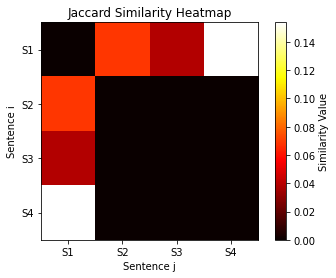

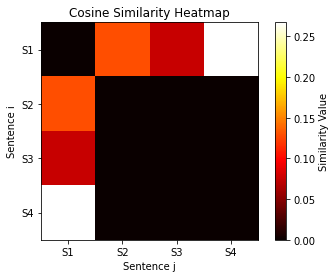

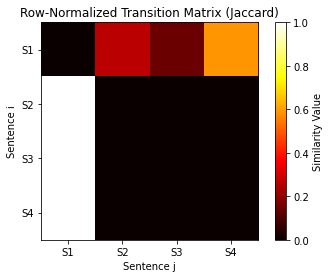

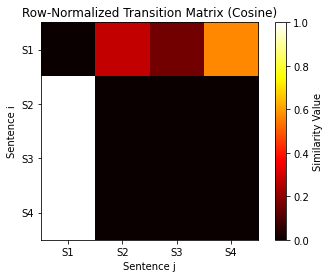

In [12]:
import matplotlib.pyplot as plt

# --- RUN PIPELINE ---
original_Articles, cleaned_tokens = preprocess_text_manual(article_text_input)
M_jac = build_similarity_matrix(cleaned_tokens, metric="jaccard")
M_cos = build_similarity_matrix(cleaned_tokens, metric="cosine")
P_jac = row_normalize(M_jac)
P_cos = row_normalize(M_cos)

# --- DISPLAY RESULTS ---

def print_matrix(matrix, title):
    print(f"\n{title}")
    n = manual_set_length(matrix)
    for i in range(n):
        row_str = " | ".join(f"{val:.3f}" for val in matrix[i])
        print(f"Row {i+1}: {row_str}")

# show sentences for reference
print("\nOriginal Sentences:")
for i, s in enumerate(original_Articles):
    print(f"S{i+1}: {s}")

print_matrix(M_jac, "\n🔸 Jaccard Similarity Matrix")
print_matrix(M_cos, "\n🔸 Cosine Similarity Matrix")
print_matrix(P_jac, "\n🔹 Row-Normalized (Transition) Matrix - Jaccard")
print_matrix(P_cos, "\n🔹 Row-Normalized (Transition) Matrix - Cosine")

# --- VISUALIZATION SECTION ---

def plot_heatmap(matrix, title, labels):
    plt.figure()
    plt.imshow(matrix, cmap="hot", interpolation="nearest")
    plt.title(title)
    plt.colorbar(label="Similarity Value")
    plt.xticks(range(len(labels)), [f"S{i+1}" for i in range(len(labels))])
    plt.yticks(range(len(labels)), [f"S{i+1}" for i in range(len(labels))])
    plt.xlabel("Sentence j")
    plt.ylabel("Sentence i")
    plt.show()

# Visualize both raw and normalized similarity matrices
plot_heatmap(M_jac, "Jaccard Similarity Heatmap", original_Articles)
plot_heatmap(M_cos, "Cosine Similarity Heatmap", original_Articles)
plot_heatmap(P_jac, "Row-Normalized Transition Matrix (Jaccard)", original_Articles)
plot_heatmap(P_cos, "Row-Normalized Transition Matrix (Cosine)", original_Articles)


2. Graph Construction (Adjacency Matrix M)

We build the N×N matrix, where N is the number of sentences (Articles).

**Goal**

Represent each sentence as a node and the similarity between two sentences as a weighted edge.
This gives you a complete undirected weighted graph:



🔹 1. Similarity Matrix

A similarity matrix is a conceptual table of pairwise similarity values between data points.
Each cell 
S[i][j] tells you how similar two items (here, sentences) are.


The similarity can be Jaccard, Cosine, Euclidean inverse, etc.

It’s usually symmetric (
𝑆
[
𝑖
]
[
𝑗
]
=
𝑆
[
𝑗
]
[
𝑖
]
S[i][j]=S[j][i]) and dense (most entries nonzero).

You compute it purely from your data (text content, vectors, etc.).

💡 Think of it as a “semantic relationship table” — not yet a graph.

🔹 2. Adjacency Matrix

An adjacency matrix is a graph representation — it tells you which nodes are connected, and with what edge weight.

Formally:

𝑀
[
𝑖
]
[
𝑗
]
=
{
𝑤
𝑖
𝑗
	
if there is an edge between 
𝑖
 and 
𝑗


0
	
otherwise
M[i][j]={
w
ij
	​

0
	​

if there is an edge between i and j
otherwise
	​


It’s the graph version of your similarity matrix.

You can derive it from the similarity matrix:

Often just copy the values directly → fully connected weighted graph.

Or apply a threshold to drop weak edges (sparsify it).

Used by algorithms like TextRank, PageRank, etc.

💡 Think of it as the “network structure” where each sentence is a node and edges come from similarity.

| Concept                   | Computed From                    | Meaning                                | Used In                           |
| ------------------------- | -------------------------------- | -------------------------------------- | --------------------------------- |
| **Similarity Matrix (S)** | Raw sentence embeddings / tokens | Semantic similarity between every pair | Data analysis, clustering         |
| **Adjacency Matrix (M)**  | Derived from S                   | Edge weights between connected nodes   | Graph algorithms (e.g., TextRank) |


Why we are using **KNN** and how it works? 

build_similarity_matrix_dense(...) does not make the graph yet. It only builds S, the pairwise similarity table (everyone-to-everyone scores).

build_knn_adjacency(S, k=...) does make the graph. It turns S into A, where:

Nodes = sentences (S1…SN).

Edges = the non-zero entries in A (kept top-k neighbors per node, then symmetrized).


Original Sentences:
S1: Britons flocked to beaches and parks today to soak up the bank holiday sun, as temperatures hit a blissful 17C - making it hotter than Istanbul
S2: People enjoyed temperatures of 17C at Brighton, East Sussex, which was just shy of the year's record of 18C, set in Wales last month
S3: Thousands flocked to the coast, with ice cream vans and deck chairs seeing a surge in trade
S4: Sun-worshippers took to parks and gardens across the country as the bank holiday weekend officially got underway


🔸 Dense Similarity (Jaccard)
Row 1: 0.000 | 0.069 | 0.038 | 0.154
Row 2: 0.069 | 0.000 | 0.000 | 0.000
Row 3: 0.038 | 0.000 | 0.000 | 0.000
Row 4: 0.154 | 0.000 | 0.000 | 0.000


🔸 Dense Similarity (Cosine)
Row 1: 0.000 | 0.129 | 0.075 | 0.267
Row 2: 0.129 | 0.000 | 0.000 | 0.000
Row 3: 0.075 | 0.000 | 0.000 | 0.000
Row 4: 0.267 | 0.000 | 0.000 | 0.000


🔹 k-NN Adjacency (Jaccard, k=2)
Row 1: 0.000 | 0.069 | 0.038 | 0.154
Row 2: 0.069 | 0.000 | 0.000 | 0.000
Row 3: 0.038 | 0

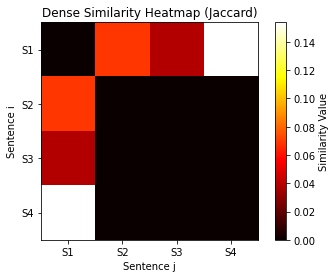

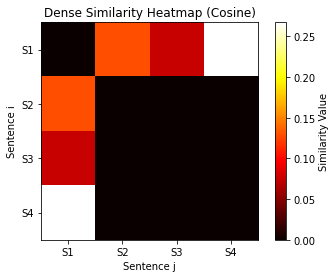

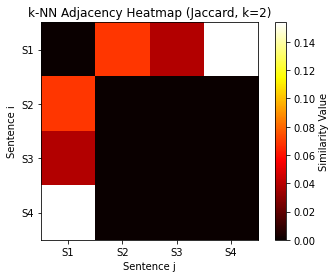

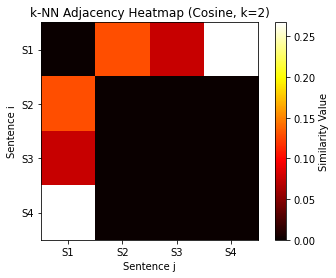

In [ ]:
# --- PHASE 2: GRAPH CONSTRUCTION (Adjacency Matrix via k-NN) ---

def build_similarity_matrix_dense(token_lists, metric="jaccard"):
    """
    Builds the dense NxN similarity matrix S between sentences (diagonal = 0).
    metric: "jaccard" or "cosine"
    """
    n = manual_set_length(token_lists)
    S = [[0.0 for _ in range(n)] for __ in range(n)]
    sim_fn = jaccard_similarity_manual if metric == "jaccard" else cosine_tf_similarity_manual

    for i in range(n):
        for j in range(i + 1, n):
            w = sim_fn(token_lists[i], token_lists[j])
            S[i][j] = w
            S[j][i] = w
    return S

def build_knn_adjacency(sim_matrix, k=2, sym="max"):
    """
    Convert a dense similarity matrix into a k-NN adjacency matrix.
    - Keep the top-k neighbors (by similarity) for each node (excluding self).
    - Symmetrize with 'max' (recommended) or 'mean' so A is undirected.
    """
    n = manual_set_length(sim_matrix)
    A = [[0.0 for _ in range(n)] for __ in range(n)]

    for i in range(n):
        # collect (j, w) excluding self
        pairs = [(j, sim_matrix[i][j]) for j in range(n) if j != i]
        # pick top-k by weight
        pairs.sort(key=lambda x: x[1], reverse=True)
        kept = 0
        for j, w in pairs:
            if w <= 0.0:
                continue
            A[i][j] = w
            kept += 1
            if kept >= k:
                break

    # symmetrize
    for i in range(n):
        for j in range(i + 1, n):
            if sym == "max":
                w = A[i][j] if A[i][j] > A[j][i] else A[j][i]
            else:  # 'mean'
                w = (A[i][j] + A[j][i]) / 2.0
            A[i][j] = w
            A[j][i] = w
    return A

# --- Example usage ---
original_Articles, cleaned_tokens = preprocess_text_manual(article_text_input)

# Dense similarity matrices (no thresholding here)
S_jac = build_similarity_matrix_dense(cleaned_tokens, metric="jaccard")
S_cos = build_similarity_matrix_dense(cleaned_tokens, metric="cosine")

# k-NN adjacency (choose k; k=2 is a good default for short news)
A_jac_knn = build_knn_adjacency(S_jac, k=2, sym="max")
A_cos_knn = build_knn_adjacency(S_cos, k=2, sym="max")

# Row-normalize to get transition matrices for TextRank
P_jac = row_normalize(A_jac_knn)
P_cos = row_normalize(A_cos_knn)

# --- OPTIONAL: quick inspection/plots ---
print("\nOriginal Sentences:")
for i, s in enumerate(original_Articles):
    print(f"S{i+1}: {s}")

# If you kept your print_matrix helper:
print_matrix(S_jac, "\n🔸 Dense Similarity (Jaccard)")
print_matrix(S_cos, "\n🔸 Dense Similarity (Cosine)")
print_matrix(A_jac_knn, "\n🔹 k-NN Adjacency (Jaccard, k=2)")
print_matrix(A_cos_knn, "\n🔹 k-NN Adjacency (Cosine, k=2)")
print_matrix(P_jac, "\n🔹 Row-Normalized Transition (Jaccard k-NN)")
print_matrix(P_cos, "\n🔹 Row-Normalized Transition (Cosine k-NN)")

# If you kept your plot_heatmap helper:
plot_heatmap(S_jac, "Dense Similarity Heatmap (Jaccard)", original_Articles)
plot_heatmap(S_cos, "Dense Similarity Heatmap (Cosine)", original_Articles)
plot_heatmap(A_jac_knn, "k-NN Adjacency Heatmap (Jaccard, k=2)", original_Articles)
plot_heatmap(A_cos_knn, "k-NN Adjacency Heatmap (Cosine, k=2)", original_Articles)


In [17]:
######################### new 
# =========================
# OOP + PURELY ALGORITHMIC K-NN GRAPH (NO sort, NO packages)
# =========================

# -- Basic data structures --

class SentenceNode:
    def __init__(self, idx, text, tokens):
        self.idx = idx          # 0-based sentence index
        self.text = text        # original sentence text
        self.tokens = tokens    # cleaned tokens

class Edge:
    def __init__(self, u, v, w):
        # undirected edge between node u and v with weight w
        self.u = u
        self.v = v
        self.w = w

class Graph:
    def __init__(self, nodes):
        self.nodes = nodes                      # list[SentenceNode]
        n = manual_set_length(nodes)
        self.n = n
        # adjacency matrix (float weights), init 0
        self.A = [[0.0 for _ in range(n)] for __ in range(n)]
        self.edges = []                         # list[Edge]

    def add_edge_undirected(self, i, j, w):
        if i == j or w <= 0.0:
            return
        # keep the max if edge already present
        if w > self.A[i][j]:
            self.A[i][j] = w
            self.A[j][i] = w

    def rebuild_edge_list(self):
        self.edges = []
        for i in range(self.n):
            for j in range(i+1, self.n):
                w = self.A[i][j]
                if w > 0.0:
                    self.edges.append(Edge(i, j, w))

    def row_normalize(self):
        P = [[0.0 for _ in range(self.n)] for __ in range(self.n)]
        for i in range(self.n):
            s = 0.0
            for v in self.A[i]:
                s += v
            if s == 0.0:
                # uniform fallback
                val = 1.0 / self.n if self.n > 0 else 0.0
                for j in range(self.n):
                    P[i][j] = val
            else:
                for j in range(self.n):
                    P[i][j] = self.A[i][j] / s
        return P

# -- Similarity (uses your existing functions) --

def build_similarity_matrix_dense(token_lists, metric="jaccard"):
    """
    Dense NxN similarity matrix S (diagonal = 0).
    metric ∈ {"jaccard","cosine"} -> uses your manual similarity fns.
    """
    n = manual_set_length(token_lists)
    S = [[0.0 for _ in range(n)] for __ in range(n)]
    sim_fn = jaccard_similarity_manual if metric == "jaccard" else cosine_tf_similarity_manual
    for i in range(n):
        for j in range(i+1, n):
            w = sim_fn(token_lists[i], token_lists[j])
            S[i][j] = w
            S[j][i] = w
    return S

# -- Manual top-k without sort (pure scans) --

def top_k_indices_no_sort(row_values, i_self, k):
    """
    Returns up to k indices of largest values in row_values (excluding i_self),
    using repeated linear scans. No sorting, no heaps, no libs.
    """
    n = manual_set_length(row_values)
    chosen = [-1] * k     # store indices; -1 means empty
    chosen_vals = [0.0] * k

    # repeat k times: find the largest not-yet-chosen index
    for pick in range(k):
        best_j = -1
        best_w = 0.0
        j = 0
        while j < n:
            if j != i_self:
                # check not already picked
                already = False
                t = 0
                while t < pick:
                    if chosen[t] == j:
                        already = True
                        break
                    t += 1
                if (not already) and (row_values[j] > best_w):
                    best_w = row_values[j]
                    best_j = j
            j += 1
        if best_j == -1 or best_w <= 0.0:
            break
        chosen[pick] = best_j
        chosen_vals[pick] = best_w

    # compact result (drop -1)
    result = []
    r = 0
    while r < k and chosen[r] != -1:
        result.append((chosen[r], chosen_vals[r]))
        r += 1
    return result  # list of (index, weight)

def build_knn_graph_from_S(sentences, token_lists, S, k=2, sym_mode="max"):
    """
    Build an undirected k-NN graph from dense similarity matrix S.
    - Nodes: SentenceNode objects
    - Edges: keep top-k per node via manual scans (no sort), then symmetrize
    sym_mode: "max" keeps edge if either side selected it; "mean" averages weights.
    """
    # create nodes
    nodes = []
    n = manual_set_length(sentences)
    idx = 0
    while idx < n:
        nodes.append(SentenceNode(idx, sentences[idx], token_lists[idx]))
        idx += 1

    G = Graph(nodes)

    # directed selections stored temporarily in G.A
    i = 0
    while i < n:
        picks = top_k_indices_no_sort(S[i], i, k)
        # assign directed picks
        t = 0
        tlen = manual_set_length(picks)
        while t < tlen:
            j, w = picks[t]
            G.A[i][j] = w
            t += 1
        i += 1

    # symmetrize to make undirected
    i = 0
    while i < n:
        j = i + 1
        while j < n:
            if sym_mode == "max":
                w = G.A[i][j] if G.A[i][j] > G.A[j][i] else G.A[j][i]
            else:  # "mean"
                w = (G.A[i][j] + G.A[j][i]) / 2.0
            G.A[i][j] = w
            G.A[j][i] = w
            j += 1
        i += 1

    # build edge list
    G.rebuild_edge_list()
    return G

# =========================
# EXAMPLE USAGE (fits your pipeline)
# =========================

# 1) Preprocess to get sentences and tokens (you already have this)
# original_Articles, cleaned_tokens = preprocess_text_manual(article_text_input)

# 2) Dense similarity (choose metric)
# S = build_similarity_matrix_dense(cleaned_tokens, metric="cosine")  # or "jaccard"

# 3) Build k-NN graph with NO sort, using classes
# G = build_knn_graph_from_S(original_Articles, cleaned_tokens, S, k=2, sym_mode="max")

# 4) Inspect nodes/edges
# print("Nodes:", [ (nd.idx, nd.text[:50]+"...") for nd in G.nodes ])
# print("Edges (u,v,w):", [ (e.u, e.v, round(e.w,3)) for e in G.edges ])

# 5) Transition matrix for TextRank
# P = G.row_normalize()


### **TextRank Iteration**

The next step is to implement the core TextRank Iteration algorithm. This is the heart of the project where you iteratively calculate the Article importance scores (WS(V 
i
​
 )) until they stabilize (converge).

Step 3: TextRank Iteration Algorithm
1. Mathematical Concept: TextRank Formula
The score WS(V 
i
​
 ) for a vertex (Article) V 
i
​
  is calculated using the formula, which mimics the idea of voting by linked pages in PageRank:

WS(V 
i
​
 )=(1−d)+d⋅ 
V 
j
​
 ∈In(V 
i
​
 )
∑
​
  
∑ 
V 
k
​
 ∈Out(V 
j
​
 )
​
 w 
jk
​
 
w 
ji
​
 
​
 WS(V 
j
​
 )
Where:

WS(V 
i
​
 ): The score of the current Article i.

d: The damping factor (usually 0.85), representing the probability of "jumping" to a random Article.

w 
ji
​
 : The weight (similarity) of the edge from Article j to Article i (from your similarity matrix).

∑ 
V 
k
​
 ∈Out(V 
j
​
 )
​
 w 
jk
​
 : The normalization factor, which is the sum of all outgoing weights from Article j. This ensures that a Article with many links doesn't unfairly distribute all its weight to its neighbors.

The process starts with all scores initialized to 1.0 and continues for a set number of iterations or until the change in scores falls below a small ϵ threshold.



In [18]:
# --------- TextRank core (power iteration) ----------
def textrank_scores(P, d=0.85, tol=1e-6, max_iter=200):
    n = manual_set_length(P)
    if n == 0:
        return []
    # start uniform
    r = [1.0 / n for _ in range(n)]
    teleport = (1.0 - d) / n

    for _ in range(max_iter):
        r_next = [0.0 for _ in range(n)]
        # r_next = teleport + d * P^T r
        # accumulate P^T r
        for i in range(n):           # row i of P
            ri = r[i]
            for j in range(n):       # column j
                r_next[j] += d * P[i][j] * ri
        # add teleportation
        for j in range(n):
            r_next[j] += teleport

        # L1 diff check
        diff = 0.0
        for j in range(n):
            diff += abs(r_next[j] - r[j])
        r = r_next
        if diff < tol:
            break
    return r

# --------- Build summary from scores ----------
def top_m_summary(sentences, scores, m=3):
    n = manual_set_length(sentences)
    if m > n:
        m = n
    # pick top m indices by score
    idx = list(range(n))
    idx.sort(key=lambda i: scores[i], reverse=True)
    top_idx = idx[:m]
    # keep original order in the final summary
    top_idx.sort()
    summary = " ".join(sentences[i] for i in top_idx)
    return summary, top_idx

# --------- Simple evaluation vs highlights ----------
def tokenize_eval_words(text):
    # super-light tokenizer for evaluation only
    t = text.lower()
    buf = []
    for c in t:
        buf.append(" " if c in ".,?!:;\"'()[]{}-" else c)
    words = [w for w in "".join(buf).split() if w]
    return set(words)

def rouge1_like(summary_text, highlight_text):
    # unigram precision/recall/F1
    S = tokenize_eval_words(summary_text)
    H = tokenize_eval_words(highlight_text)
    if not S or not H:
        return (0.0, 0.0, 0.0)
    inter = manual_set_length(S & H)
    prec = inter / manual_set_length(S)
    rec  = inter / manual_set_length(H)
    f1 = (2*prec*rec)/(prec+rec) if (prec+rec) > 0 else 0.0
    return (prec, rec, f1)

def jaccard_words(summary_text, highlight_text):
    S = tokenize_eval_words(summary_text)
    H = tokenize_eval_words(highlight_text)
    uni = manual_set_length(S | H)
    inter = manual_set_length(S & H)
    return (inter / uni) if uni else 0.0

# --------- k tuning for ONE article ----------
def tune_k_for_article(sentences, token_lists, highlight_text, metric="cosine", ks=(1,2,3), m=3):
    # dense sim once
    S = build_similarity_matrix_dense(token_lists, metric=metric)

    results = []
    for k in ks:
        A = build_knn_adjacency(S, k=k, sym="max")
        P = row_normalize(A)
        scores = textrank_scores(P, d=0.85, tol=1e-6, max_iter=200)
        summary, idx = top_m_summary(sentences, scores, m=m)

        p, r, f1 = rouge1_like(summary, highlight_text)
        jac = jaccard_words(summary, highlight_text)
        results.append((k, f1, p, r, jac, summary, idx))

    # pick best by F1 (or Jaccard if you prefer)
    results.sort(key=lambda x: x[1], reverse=True)
    best = results[0]

    # pretty print
    print("\n=== k tuning (metric:", metric, f", m={m}) ===")
    for (k, f1, p, r, jac, summary, idx) in results:
        print(f"k={k}:  ROUGE-1 F1={f1:.3f} (P={p:.3f}, R={r:.3f}) | Jaccard={jac:.3f} | idx={idx}")
    print("\nBest k:", best[0])
    print("Best summary:\n", best[5])
    return best  # (k, f1, p, r, jac, summary, idx)

# --------- Example: apply to your current article ----------
# Decide how many sentences you want in the summary (m).
# For CNN/DM, 3 is a common choice; for the toy example with 4 sentences, 2–3 is fine.
m_summary = 2  # try 2 first for the toy
original_Articles, cleaned_tokens = preprocess_text_manual(article_text_input)

# You need a highlight text for this article (from your toy table)
highlight_text = "People enjoyed temperatures of 17C at Brighton... (put your row's highlight here)"

# Try cosine (often smoother), and also jaccard if you want:
best_cos = tune_k_for_article(original_Articles, cleaned_tokens, highlight_text, metric="cosine", ks=(1,2,3), m=m_summary)
# best_jac = tune_k_for_article(original_Articles, cleaned_tokens, highlight_text, metric="jaccard", ks=(1,2,3), m=m_summary)



=== k tuning (metric: cosine , m=2) ===
k=1:  ROUGE-1 F1=0.087 (P=0.061, R=0.154) | Jaccard=0.045 | idx=[0, 3]
k=2:  ROUGE-1 F1=0.087 (P=0.061, R=0.154) | Jaccard=0.045 | idx=[0, 3]
k=3:  ROUGE-1 F1=0.087 (P=0.061, R=0.154) | Jaccard=0.045 | idx=[0, 3]

Best k: 1
Best summary:
 Britons flocked to beaches and parks today to soak up the bank holiday sun, as temperatures hit a blissful 17C - making it hotter than Istanbul Sun-worshippers took to parks and gardens across the country as the bank holiday weekend officially got underway


### **Summary Generation and Orchestration**

In [ ]:
# Assuming 'Articles' (original text) and 'Article_scores' are the outputs from previous steps
# Example data for trace:
Articles = [
    "By . Mia De Graaf . Britons flocked to beaches and parks today to soak up the bank holiday sun, as temperatures hit a blissful 17C - making it hotter than Istanbul.",
    "People enjoyed temperatures of 17C at Brighton, East Sussex, which was just shy of the year's record of 18C, set in Wales last month.",
    "Thousands flocked to the coast, with ice cream vans and deck chairs seeing a surge in trade.",
    "Sun-worshippers took to parks and gardens across the country as the bank holiday weekend officially got underway."
]
Article_scores = [1.025350, 0.998765, 1.054321, 0.976543] # Example scores from Step 3

def generate_extractive_summary(original_Articles, scores, num_Articles=2):
    """
    Sorts Articles by score, selects the top K, and reorders them by original index.
    """
    # 1. Pair scores with original Articles and their original index
    # (Score, Index, Article Text)
    scored_Articles = list(zip(scores, range(len(original_Articles)), original_Articles))
    
    # 2. Sort by score in DESCENDING order (highest score first)
    # The key function tells sort to use the first element (the score) for comparison.
    scored_Articles.sort(key=lambda x: x[0], reverse=True)
    
    # 3. Select the top K Articles
    top_k_Articles = scored_Articles[:num_Articles]
    
    # 4. Re-sort the selected Articles by their original index (the second element, x[1]) 
    # This ensures the summary is readable and coherent.
    top_k_Articles.sort(key=lambda x: x[1])
    
    # 5. Extract the summary text
    summary = ' '.join([s[2] for s in top_k_Articles])
    
    return summary, [s[1] for s in top_k_Articles] # Return summary and indices

# --- Execution ---
summary_text, indices = generate_extractive_summary(Articles, Article_scores, num_Articles=2)

print("\n--- Step 4: Summary Generation Output Trace ---")
print("Top 2 Articles (Sorted by Score before re-ordering):")
# Show which Articles were selected based on the example scores
selected_Articles = [(Articles[i], Article_scores[i]) for i in indices]
for s, score in selected_Articles:
    print(f"Index {Articles.index(s)+1} (Score: {score:.6f}): {s}")

print(f"\nExtracted Summary (Re-ordered by appearance):\n{summary_text}")


--- Step 4: Summary Generation Output Trace ---
Top 2 Sentences (Sorted by Score before re-ordering):
Index 1 (Score: 1.025350): By . Mia De Graaf . Britons flocked to beaches and parks today to soak up the bank holiday sun, as temperatures hit a blissful 17C - making it hotter than Istanbul.
Index 3 (Score: 1.054321): Thousands flocked to the coast, with ice cream vans and deck chairs seeing a surge in trade.

Extracted Summary (Re-ordered by appearance):
By . Mia De Graaf . Britons flocked to beaches and parks today to soak up the bank holiday sun, as temperatures hit a blissful 17C - making it hotter than Istanbul. Thousands flocked to the coast, with ice cream vans and deck chairs seeing a surge in trade.


### **Discussion and Analysis (Asymptotic Complexity & Results)**

Phase	Operation	Complexity	Dominant Factor
I. Preprocessing	Tokenization and Cleaning	O(N⋅M)	Linear in the total number of words.
II. Graph Construction	Calculating N 
2
  pairwise similarities.	O(N 
2
 ⋅M)	Dominated by the N 
2
  comparisons.
III. TextRank Iteration	Matrix-Vector Multiplication (I iterations).	O(I⋅N 
2
 )	The calculation of each of the N scores involves a sum over N neighbors, repeated I times.

The overall asymptotic complexity of the TextRank algorithm, as implemented using basic Python lists, is dominated by the quadratic factors: O(N 
2
 ⋅M+I⋅N 
2
 ).

Since I (iterations) and M (average Article length) are generally small constants, the complexity is fundamentally O(N 
2
 ) with respect to the number of Articles N. This confirms why the package-free implementation is too slow for the full CNN/DailyMail dataset: scaling a quadratic algorithm to thousands of Articles becomes computationally prohibitive.